$\frac{dx(t)}{dt} = \sigma(y(t) - x(t))\\$

$\frac{dy(t)}{dt} = R x(t) - y(t) - x(t)z(t)\\$


$\frac{dz(t)}{dt} = x(t)y(t) - Bz(t)\\$

$x(0) = c_{1}, y(0) = c_{2}, z(0) = c_{3}\\$


$\sigma = 0.1 \\ R = 0.2 \\ B = 0.3 \\ c_{1} = 0, c_{2} = 1, c_{3} = 0$





In [1]:
import sys
import torch 
import torch.nn as nn 
import torch.optim as optim 
import numpy as np 
from tqdm import tqdm

from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 


from utils.MLP import MLP, set_seed
from utils.data import MyDataset, SubdomainDataLoader, DataSampler
import copy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mse = torch.nn.MSELoss()
set_seed(42)

In [3]:
START_T = 0
END_T = 50
TOTAL_POINTS = 1000

INPUT_SHAPE = 1
OUTPUT_SHAPE = 3
NUM_HIDDEN_LAYER = 2
NUM_HIDDEN_NEURON = 20
NUM_SUBDOMAIN = 5


EPOCHS = 50000

SIGMA_ = 0.1
R_ = 0.2
B_ = 0.3
C1_ = 0
C2_ = 1
C3_ = 0


T0 = torch.tensor([[0.0]]).requires_grad_(True)
X0 = torch.tensor([C1_, C2_, C3_], dtype=torch.float).reshape(1, -1)

In [4]:
def system(t, state, sigma, rho, beta):
    x, y, z = state
    dx_dt = sigma * (y-x)
    dy_dt = x * (rho - z) - y 
    dz_dt = x*y - beta* z 
    return [dx_dt, dy_dt, dz_dt]

initial_state = X0.numpy().squeeze(0)
t_span = (START_T, END_T)
t_eval = np.linspace(START_T, END_T, TOTAL_POINTS)
x_num_sol = solve_ivp(system, t_span=t_span, y0=initial_state, args=(SIGMA_,R_, B_), t_eval=t_eval, method='RK45')

x_num = torch.tensor(x_num_sol.y[0].reshape(-1, 1))
y_num = torch.tensor(x_num_sol.y[1].reshape(-1, 1))
z_num = torch.tensor(x_num_sol.y[2].reshape(-1, 1))

In [5]:
class PWNN:
    def __init__(self,
                 start_value: float, 
                 end_value: float,
                 num_of_points: int,
                 num_subdomain: int,

                 input_dim: int = 1,
                 output_dim: int = 1, 
                 hidden_layers:int=2,
                 num_hidden_neurons: int=20,
                 ):
        self.start_value = start_value
        self.end_value = end_value
        self.num_of_points = num_of_points
        self.num_subdomain = num_subdomain

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_layers = hidden_layers
        self.num_hidden_neurons = num_hidden_neurons
        assert self.num_of_points % self.num_subdomain == 0, "Number of Data points must be divisible by number of subdomains"


        self.subdomina_intervals = self.get_domain_intervals(self.start_value, self.end_value, self.num_subdomain)
        self.num_of_points_subdomain = self.num_of_points/num_subdomain
        
        self.whole_dataset = MyDataset(start=self.start_value, end = self.end_value, total_points=self.num_of_points, num_subdomain=self.num_subdomain)
        self.dataloader = SubdomainDataLoader(self.whole_dataset)

        self.nets = []



    def train(self, num_epochs, lr = 0.01):
        
        for d_n, data in enumerate(self.dataloader):
            
            if d_n == 0:
                model = MLP(self.input_dim, self.output_dim, self.hidden_layers, self.num_hidden_neurons)
            else:
                model = MLP(self.input_dim, self.output_dim, self.hidden_layers, self.num_hidden_neurons)
                model.load_state_dict(copy.deepcopy(self.nets[-1].state_dict()))
            
            optimizer = None
            optimizer = torch.optim.Adam(model.parameters(), lr = lr)
            lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer = optimizer, step_size=500, gamma=0.8)


            if d_n == 0:
                T0 = torch.tensor([[0.0]]).requires_grad_(True)
                X0 = torch.tensor([C1_, C2_, C3_], dtype=torch.float).reshape(1, -1)
            else:
                T0 = torch.tensor([[self.subdomina_intervals[d_n-1][1]]]).requires_grad_(True)
                
                prev_model = copy.deepcopy(self.nets[-1])
                X0 = prev_model(T0).detach()
            pbar = tqdm(range(num_epochs), desc=f'Training Model-{d_n+1}', leave=True, file=sys.stdout)
            
            for step in pbar:
                indices = torch.randperm(data.size(0))
                shuffled_data = data[indices].requires_grad_(True)
                model.train()
                optimizer.zero_grad()
                mx = model(shuffled_data)
                mx0 = model(T0)

                loss = self.loss_fn(shuffled_data, mx, X0, mx0)
                loss.backward()
                optimizer.step()
                lr_scheduler.step()

                pbar.set_postfix_str(f'Loss : {loss.item() :.20f}')

            self.nets.append(model)

                

            
    def loss_fn(self, t, my, y0, my0):
        my_ = my


        x = my_[:, 0:1]
        y = my_[:, 1:2]
        z = my_[:, 2:3]

        dx_dt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(t), create_graph=True)[0]
        dy_dt = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(t), create_graph=True)[0]
        dz_dt = torch.autograd.grad(z, t, grad_outputs=torch.ones_like(t), create_graph=True)[0]

        x_loss = torch.mean(5*(dx_dt - SIGMA_*(y - x))**2)
        y_loss = torch.mean(5*(dy_dt - x*(R_-z) + y)**2)
        z_loss = torch.mean(5*(dz_dt - x*y + B_*z)**2)

        init_loss = torch.mean((y0 - my0)**2)
        total_loss = x_loss + y_loss + z_loss + init_loss

        return total_loss



    def get_domain_intervals(self, start, end, division):
        each_subdomain_size = (end - start)/division
        intervals = []

        for i in range(division):
            itv = [start+ i*each_subdomain_size, start + (i+1)*each_subdomain_size]
            intervals.append(itv)

        return intervals
    
    def predict(self):
        full_domain = torch.linspace(self.start_value, self.end_value, self.num_of_points).reshape(-1, 1)
        preds = []
        for d_n in range(self.num_subdomain):
            data = full_domain[int(d_n*self.num_of_points_subdomain) : int((d_n+1)*self.num_of_points_subdomain)]
            with torch.no_grad():
                model = copy.deepcopy(self.nets[d_n])
                model.eval()
                preds.append(model(data))
        return torch.cat(preds, dim=0)


In [6]:
pwnn = PWNN(start_value=START_T, 
            end_value=END_T, 
            num_of_points=TOTAL_POINTS,
            num_subdomain=NUM_SUBDOMAIN,
            hidden_layers=NUM_HIDDEN_LAYER,
            num_hidden_neurons=NUM_HIDDEN_NEURON, 
            input_dim=1, 
            output_dim=3
            )

In [7]:
### Training 
pwnn.train(int(EPOCHS/NUM_SUBDOMAIN), 0.01)

Training Model-5: 100%|██████████| 10000/10000 [00:53<00:00, 186.68it/s, Loss : 0.00000011219135842566]


In [8]:
m_sol = pwnn.predict()

In [9]:
m_x = m_sol[:, 0:1]
m_y = m_sol[:, 1:2]
m_z = m_sol[:, 2:3]


x_error = torch.sqrt(mse(m_x, x_num))
y_error = torch.sqrt(mse(m_y, y_num))
z_error = torch.sqrt(mse(m_z, z_num))

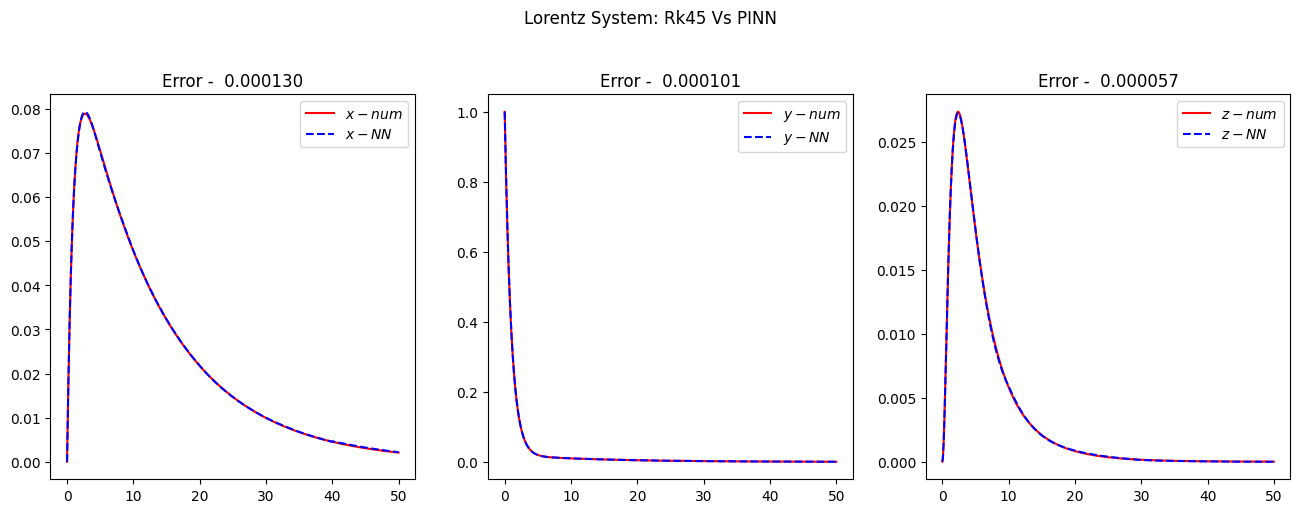

In [10]:


fig, axs = plt.subplots(1, 3, figsize=(16, 5))

axs[0].plot(t_eval, x_num, 'r', label = r'$x-num$')
axs[0].plot(t_eval, m_x, 'b--', label = r'$x-NN$')
axs[0].set_title(f'Error - {x_error : 5f}')
axs[0].legend()

axs[1].plot(t_eval, y_num, 'r', label = r'$y-num$')
axs[1].plot(t_eval, m_y, 'b--', label = r'$y-NN$')
axs[1].set_title(f'Error - {y_error : 5f}')
axs[1].legend()

axs[2].plot(t_eval, z_num, 'r', label = r'$z-num$')
axs[2].plot(t_eval, m_z, 'b--', label = r'$z-NN$')
axs[2].set_title(f'Error - {z_error : 5f}')
axs[2].legend()





plt.suptitle('Lorentz System: Rk45 Vs PINN', y = 1.05)


plt.savefig('Lorentz_PWNN.jpg', dpi = 500)
plt.show()

In [11]:
x_error_domain = torch.abs(x_num - m_x)
y_error_domain = torch.abs(y_num - m_y)
z_error_domain = torch.abs(z_num - m_z)

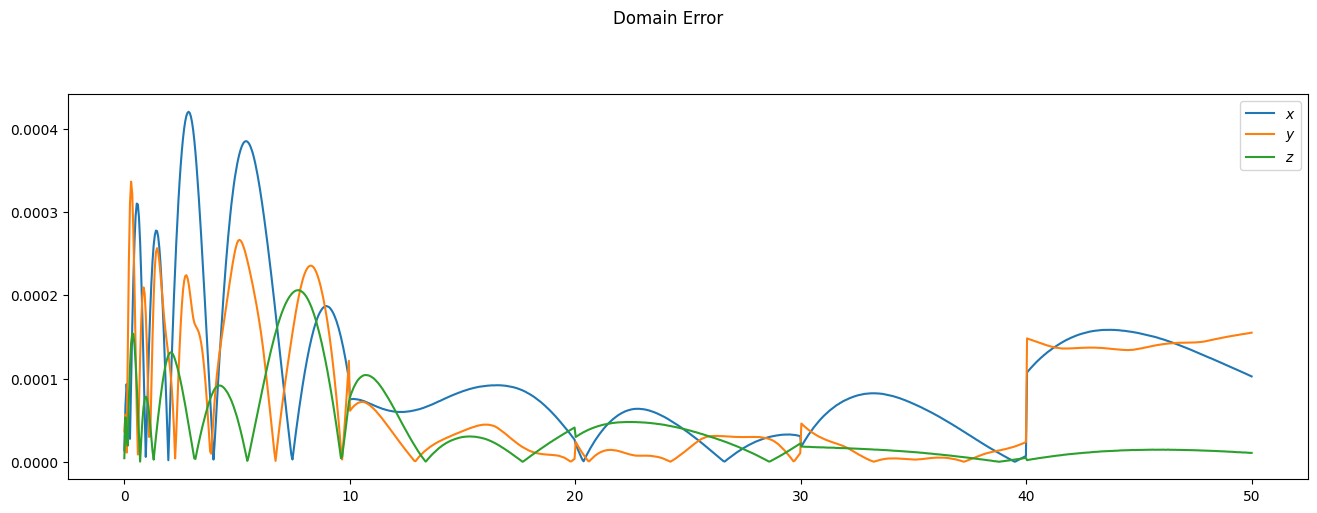

In [12]:


fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(t_eval, x_error_domain, label = r'$x$')
ax.plot(t_eval, y_error_domain, label = r'$y$')
ax.plot(t_eval, z_error_domain, label = r'$z$')
ax.legend()




plt.suptitle('Domain Error', y = 1.05)
plt.show()

In [14]:
pwwn_sol = torch.concat((m_x, m_y, m_z), dim=1).numpy()


In [15]:
np.save('Data/PWNN_Solve.npy', pwwn_sol)